<a href="https://colab.research.google.com/github/isidora00/MU_Wine_Predictions/blob/main/01_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje vrste i kvaliteta vina iz njegovih fizičkih svojstava

Kvalitet vina je ključan za konzumere kao i za proizvođače u vinskoj industriji. Sertifikacija kvaliteta proizvoda postaje sve važnija za povećanje tržišne vrednosti i prodaje. Tradicionalno, testiranje kvaliteta vina vrši se na kraju proizvodnog procesa, što je vremenski zahtevno i resursno intenzivno. Ovaj pristup zahteva angažovanje brojnih stručnjaka za procenu, što može biti skupo i subjektivno, s obzirom na različite mišljenja i standarde procene.

Kako bi se poboljšala efikasnost i tačnost u proceni kvaliteta vina, možemo koristiti objektivne metode koje mogu smanjiti zavisnost od ljudskih procena. Različite karakteristike vina mogu uticati na njegov kvalitet, ali nisu sve od njih relevantne za precizno predviđanje.
U ovom projektu koristimo mašinsko učenje da bismo identifikovali ključne karakteristike vina i omogućili preciznije i efikasnije ocenjivanje njegovog kvaliteta.

## Skup podataka
Skup podataka koji ćemo koristiti za ovaj problem je javno dostupan na sledećem linku https://archive.ics.uci.edu/dataset/186/wine+quality. Ovaj skup podataka sadrži 6497 primeraka portugalskog vina *vinho verde*. Podaci su nebalansirano raspodeljeni između dve vrste vina: 75% uzoraka su bela vina (4898), dok 25% čine crvena vina (1599). Svaki uzorak je opisan sa 11 fizičko-hemijskih karakteristika, koje su sve neprekidne veličine: fiksna kiselost, hlapiva kiselost, koncentracija limunske kiseline, sadržaj rezidualnog šećera, koncentracije hlorida, sadržaj slobodnog sumpor-dioksida, ukupan sadržaj sumpor-dioksida, gustina, pH, koncentracije sulfata i sadržaj alkohola. Svakom uzorku dodeljene su i dve oznake: stil vina (crveno ili belo) i subjektivna ocena (celi brojevi između 0 i 10) koju je odredio panel od tri somelijera.

In [1]:
pip -q install seaborn ucimlrepo plotly

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, model_selection, metrics
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance

In [3]:
# Fetch dataset
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)
df = wine_quality.data

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non


Vidimo da nemamo nedostajuće vrednosti ni u jednoj koloni. Sledi kratak opis svih raspoloživih karakteristika vina:
- **fixed_acidity**: Nehlapljive kiseline koje se ne isparavaju lako.
- **volatile_acidity**: Visoka koncentracija octene kiseline u vinu koja može dovesti do neprijatnog ukusa sirćeta.
- **citric_acid**: Deluje kao konzervans koji povećava kiselost. U malim količinama, dodaje svežinu i ukus vinima.
- **residual_sugar**: Količina šećera koja ostaje nakon što fermentacija završi. Ključno je postići savršen balans između slatkoće i kiselosti. Važno je napomenuti da vina sa više od 45 g/l su slatka.
- **chlorides**: Količina soli u vinu.
- **free_sulfur_dioxide**: Sprečava rast mikroba i oksidaciju vina.
- **total_sulfur_dioxide**: Količina slobodnih i vezanih oblika SO2.
- **density**: Slađa vina imaju veću gustinu.
- **pH**: Opisuje nivo kiselosti na skali od 0 do 14. Većina vina se kreće između 3 i 4 na pH skali.
- **sulphates**: Dodatak u vinu koji doprinosi nivou SO2 i deluje kao antimikrobni i antioksidantni agent.
- **alcohol**: Prisutan u malim količinama u vinima.

## Pretprocesiranje podataka
### Podela podataka na skup za treniranje i skup za testiranje
Na samom početku podatke delimo na skup za treniranje i skup za testiranje. Na skupu za testiranje ćemo podesiti hiperparametre modela i trenirati sam model. Skup za testiranje sadrži 25% podataka i pomoću njega ćemo testirati model.

In [4]:
# Podela na trening i test skup
X = df.features
y = df.targets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

### Raspodela vrednosti atributa

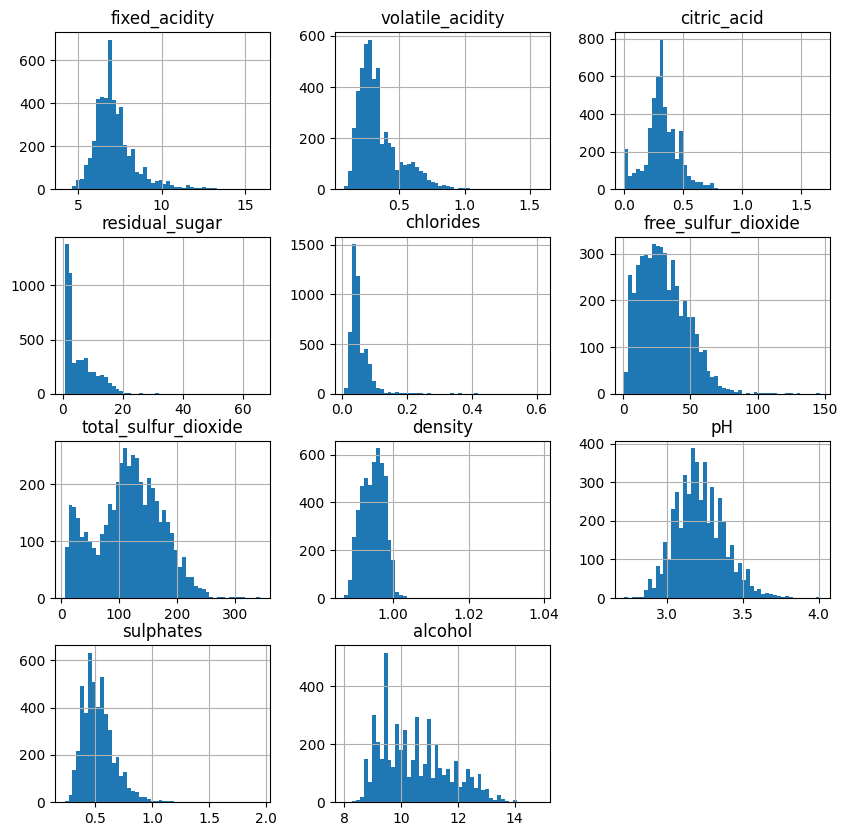

In [5]:
pd.DataFrame(X_train).hist(figsize=(10,10),bins=50)
plt.show()

### Broj instanci po kategoriji vina


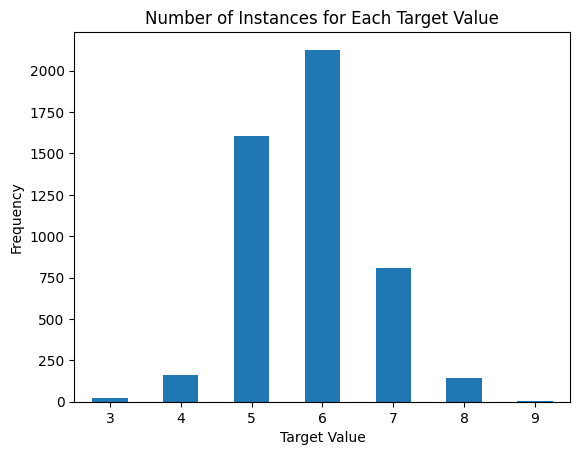

In [6]:
value_counts = pd.DataFrame(y_train).value_counts().sort_index()
# Plot
ax = value_counts.plot(kind='bar')

ax.set_xticklabels([x[0] for x in value_counts.index] )
plt.xlabel('Target Value')
plt.ylabel('Frequency')      #
plt.title('Number of Instances for Each Target Value')
plt.xticks(rotation=0)
plt.show()

## Standardizacija atributa
Standardizovaćemo atribute za sve modele kako bismo osigurali konzistentnost u predobradi podataka. Skalar koji ćemo koristiti za standardizaciju biće definisan kao hiperparametar modela, a njegovu vrednost ćemo optimizovati kroz unakrsnu validaciju.

## Analiza glavnih komponenti
Analiza glavnih komponenti (PCA) je tehnika koja se koristi za smanjenje dimenzionalnosti podataka. Njena glavna svrha je identifikacija i izdvajanje glavnih komponenti, odnosno varijabli koje objašnjavaju najveći deo varijanse u skupu podataka.

PCA se često primenjuje u analizi podataka, mašinskom učenju i obradi slika kako bi se pojednostavio model, smanjila količina informacija za analizu ili vizualizovali višedimenzionalni podaci u dvodimenzionalnom prostoru. Takođe, PCA pomaže u identifikaciji obrazaca i korelacija među varijablama, što može biti od velike koristi istraživačima i analitičarima prilikom donošenja odluka ili interpretacije rezultata.

Razumevanje povezanosti između različitih atributa je ključno u analizi podataka, jer može uticati na performanse modela i interpretaciju rezultata. Matrica korelacije omogućava vizualizaciju i analizu odnosa između varijabli u skupu podataka.

Na primer, atributi kao što su fiksna kiselost i gustina imaju visoku korelaciju sa koeficijentom od 0,46, što ukazuje na značajnu povezanost. S druge strane, atributi poput hlorida i koncentracije limunske kiseline imaju nižu korelaciju sa koeficijentom od 0,04, što sugeriše da su manje povezani.

Za svaki model koristićemo analizu glavnih komponenti (PCA), pri čemu će broj glavnih komponenti biti definisan kao hiperparametar modela.

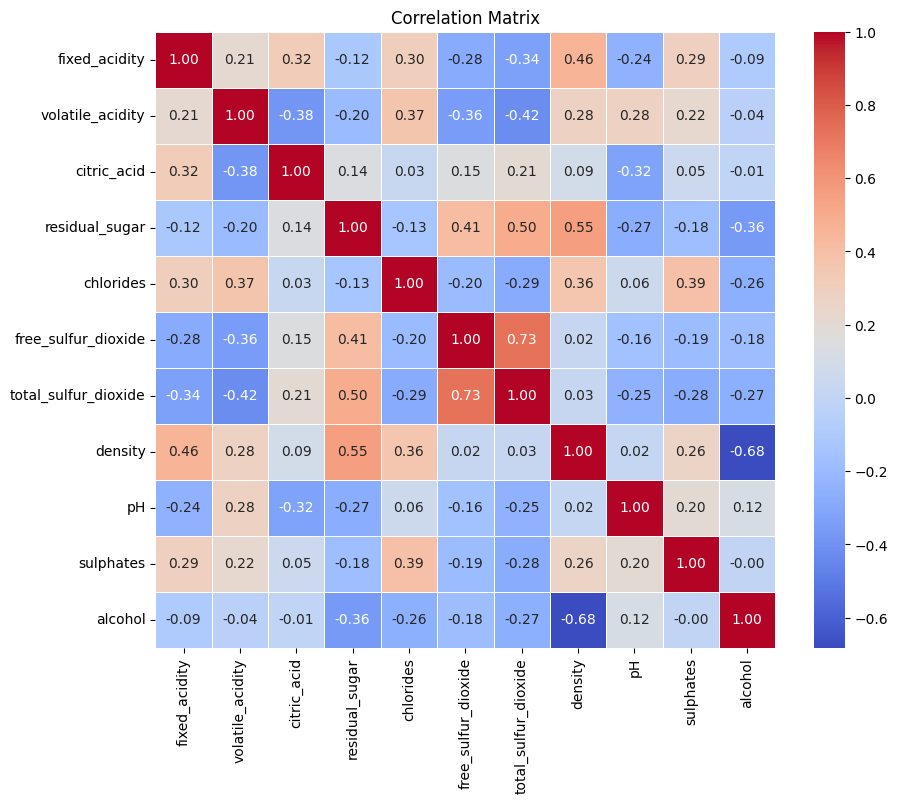

In [7]:
correlation_matrix = pd.DataFrame(X_train).corr() # koefcijijenti korelacija atributa
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5) # toplotna mapa za prikaz koeficijenata
plt.title('Correlation Matrix')
plt.show()

## Modeli

Na modelima linearne regresije, slučajne šume, svm, naive-bayes i adaboost-a ćemo unakrsnom validacijom na trening skupu naći najbolje hiperparametre, parametre i ocene rada modela. Na osnovu tih ocena, izabraćemo najbolji model i njega evaluirati konačno na test skupu.

Koristićemo PCA za smanjenje dimenzionalnosti podataka i GridSearchCV za optimizaciju modela.

### Linearna regresija sa regularizacijom

In [8]:
# Hiperparametri
pipeline_lr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('regressor', linear_model.Ridge())
])

param_grid_lr = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'regressor__alpha': [0.1, 1, 10, 100]
}

In [9]:
# Unakrsna validacija na trening skupu
grid_search_lr = model_selection.GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='r2',return_train_score=True, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

print("Best score for Linear Regression: ", grid_search_lr.best_score_)
print("Best parameters for Linear Regression: ", grid_search_lr.best_params_)

Best score for Linear Regression:  0.28880159166639496
Best parameters for Linear Regression:  {'pca__n_components': 11, 'regressor__alpha': 10}


In [10]:
def plot_test_train_scores(best_results, cv):

  # Test i trening scores
  scores_tests = best_results[[f'split{i}_test_score' for i in range(cv)]].values.flatten()
  scores_train = best_results[[f'split{i}_train_score' for i in range(cv)]].values.flatten()

  # Labele
  labels = [f'Split {i}' for i in range(cv)]

  lower_bound = min(min(scores_tests),min(scores_train))
  upper_bound = max(max(scores_tests),max(scores_train))

  def create_bar_chart(ax, scores, labels, title):
      bars = ax.bar(labels, scores, color=plt.cm.Blues(np.linspace(0.3, 1, len(scores))), edgecolor='black', linewidth=1.2)

      for bar in bars:
          yval = bar.get_height()
          ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

      ax.set_xlabel('Splits', fontsize=12)
      ax.set_ylabel('Scores', fontsize=12)
      ax.set_title(title, fontsize=14)
      ax.set_ylim(lower_bound - 0.05, upper_bound + 0.05)
      ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
      ax.tick_params(axis='x', rotation=45, labelsize=10)
      ax.grid(axis='y', linestyle='--', alpha=0.7)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  create_bar_chart(ax1, scores_tests, labels, 'Test Scores for Each Split')
  create_bar_chart(ax2, scores_train, labels, 'Train Scores for Each Split')

  plt.tight_layout()
  plt.show()

  ## Srednje vrednosti za trening i validacioni skup
  print("Mean train set score: ", best_results['mean_train_score'].values[0])
  print("Mean validation set score: ", best_results['mean_test_score'].values[0])
  print("Standard deviation train set: ", np.std(scores_train))
  print("Standard deviation validation set: ", np.std(scores_tests))


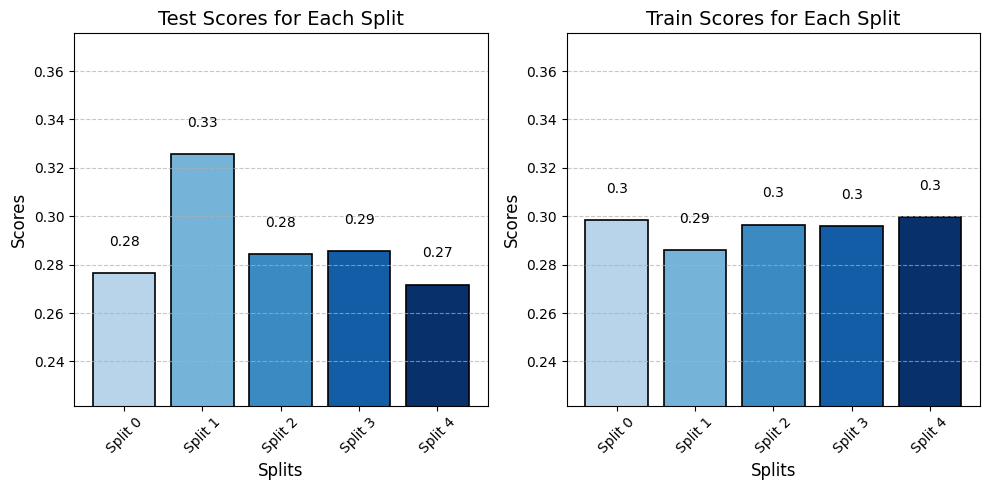

Mean train set score:  0.29528877082842175
Mean validation set score:  0.28880159166639496
Standard deviation train set:  0.004772377352336231
Standard deviation validation set:  0.01908038373583539


In [11]:
  results = pd.DataFrame(grid_search_lr.cv_results_)
  best_params = grid_search_lr.best_params_
  best_results = results[
      (results['param_pca__n_components'] == best_params['pca__n_components']) &
      (results['param_regressor__alpha'] == best_params['regressor__alpha'])
  ]
plot_test_train_scores(best_results, grid_search_lr.cv)

### Analiza rezultata
Rezultati pokazuju da model objašnjava samo oko 29% varijacije u podacima, što ukazuje na lošu sposobnost predikcije. Sličnost između R² score-a za trening i validacione skupove, uz nisku standardnu devijaciju, sugeriše da model nije overfittovan. Potrebno je istražiti mogućnosti za poboljšanje modela, kao što su dodavanje novih atributa ili korišćenje složenijih modela, kako bi se povećala njegova preciznost.

In [12]:
models = []
# Ispis grešaka za model
def print_errors(y, y_pred, model_name):
    # Mean Squared Error
    mse = metrics.mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)

    # Mean Absolute Error
    mae = metrics.mean_absolute_error(y, y_pred)
    print("Mean Absolute Error: ", mae)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: ", rmse)

    # R-squared
    r2 = metrics.r2_score(y, y_pred)
    print("R-squared: ", r2)

    # Median Absolute Error
    median_ae = metrics.median_absolute_error(y, y_pred)
    print("Median Absolute Error: ", median_ae)

    # Explained Variance Score
    explained_variance = metrics.explained_variance_score(y, y_pred)
    print("Explained Variance Score: ", explained_variance)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print("Mean Absolute Percentage Error: {:.2f}%".format(mape))

    model = {
        'Model' : model_name,
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Median_AE': median_ae, 'Explained_Variance': explained_variance, 'MAPE': mape
    }

    return model

### Provera parametara na toplotnoj mapi
Možemo da koristimo toplotne mape da se uverimo da pretražujemo dobre skupove parametara. Iz ovih rezultata vidimo da možemo pretraživati i veće vrednosti za *regressor__alpha* parametar.

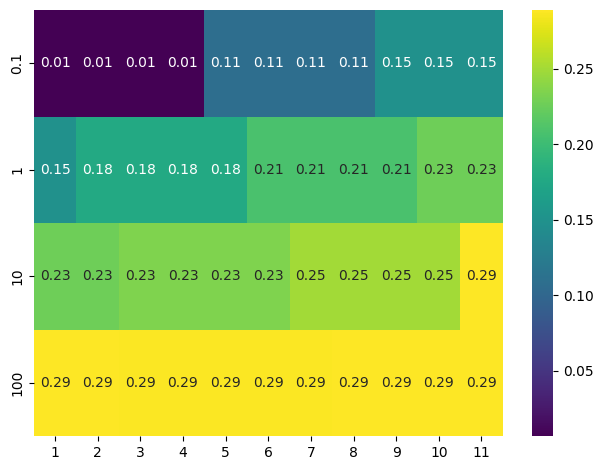

In [13]:
cv_results = pd.DataFrame(grid_search_lr.cv_results_)

cv_test_score = cv_results['mean_test_score'].values.reshape(4, 11)

alfas = [0.1, 1, 10, 100]
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

sb.heatmap(cv_test_score, xticklabels=n_components, yticklabels=alfas, cmap='viridis', annot=True, fmt='.2f')


plt.tight_layout()
plt.show()

### Naive-Bayes

In [14]:
# Hiperparametri
pipeline_nb = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('classifier', GaussianNB())
])

param_grid_nb = {
    'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
}

In [15]:
# Unakrsna validacija
grid_search_nb = model_selection.GridSearchCV(pipeline_nb, param_grid_nb, cv=3, scoring='r2', return_train_score=True, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)
best_model_nb = grid_search_nb.best_score_

print("Best cross-validation score for Naive-Bayes: ",best_model_nb)
print("Best parameters for Naive-Bayes: ", grid_search_nb.best_params_)

Best cross-validation score for Naive-Bayes:  0.03078266879143136
Best parameters for Naive-Bayes:  {'pca__n_components': 9}


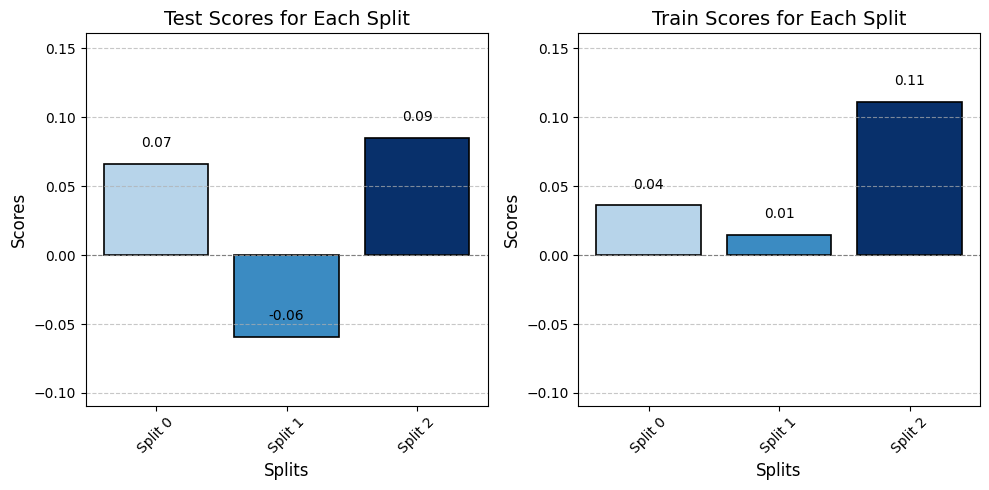

Mean train set score:  0.05395911366747145
Mean validation set score:  0.03078266879143136
Standard deviation train set:  0.0412366426658253
Standard deviation validation set:  0.06409442036470213


In [16]:
results = pd.DataFrame(grid_search_nb.cv_results_)
best_params = grid_search_nb.best_params_

best_results = results[
    (results['param_pca__n_components'] == best_params['pca__n_components'])
]
plot_test_train_scores(best_results, grid_search_nb.cv)

### Analiza rezultata
Rezultati primene Naive Bayes metode pokazuju da model objašnjava samo oko 3.2% varijacije u podacima za trening skup, dok za validacijski skup R² score pada ispod nule, što sugeriše da model ne obavlja bolje od prostog proseka ciljne promenljive. Niska standardna devijacija za trening skup ukazuje na doslednost rezultata, ali rezultati su i dalje jako loši.

## SVR

In [17]:
# Hiperparametri
pipeline_svr = Pipeline([
    ('scalar', StandardScaler()),
    ('pca', PCA()),
    ('svr', SVR())
])

param_grid_svr = {
    'pca__n_components': [8, 9, 10, 11],
    'svr__C': [0.01 ,0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 1],
    'svr__gamma' : ['scale','auto']
}

In [18]:
# Unakrsna validacija
grid_search_svr = model_selection.RandomizedSearchCV(pipeline_svr, param_grid_svr, n_iter = 50, cv=3, scoring='r2', return_train_score=True, n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
best_model_svr = grid_search_svr.best_score_

print("Best cross-validation score for SVR: ",best_model_svr)
print("Best parameters for SVR: ", grid_search_svr.best_params_)

Best cross-validation score for SVR:  0.3741070525365234
Best parameters for SVR:  {'svr__gamma': 'auto', 'svr__epsilon': 0.2, 'svr__C': 1, 'pca__n_components': 10}


{'svr__gamma': 'auto', 'svr__epsilon': 0.2, 'svr__C': 1, 'pca__n_components': 10}


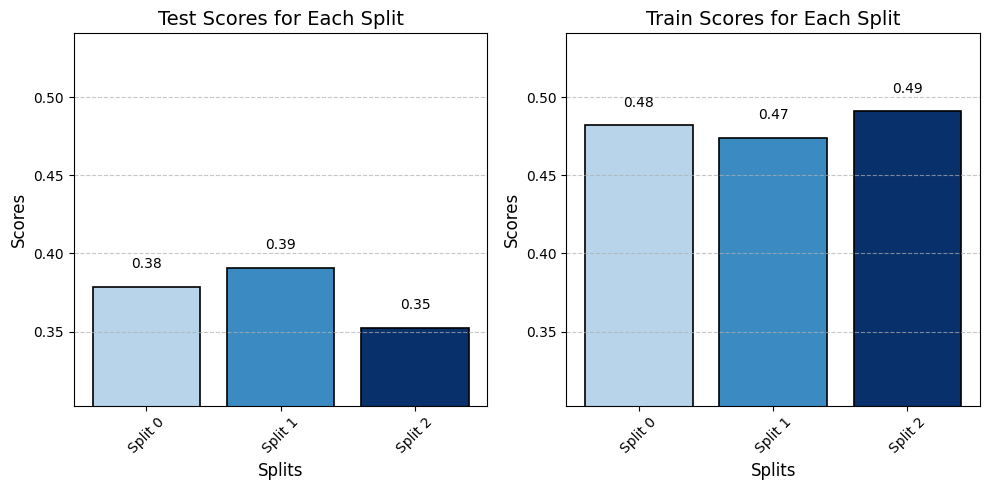

Mean train set score:  0.48232448169793624
Mean validation set score:  0.3741070525365234
Standard deviation train set:  0.006932230629765242
Standard deviation validation set:  0.015979290559763982


In [19]:
results = pd.DataFrame(grid_search_svr.cv_results_)
best_params = grid_search_svr.best_params_
print(best_params)
best_results = results[
    (results['param_pca__n_components'] == best_params['pca__n_components']) &
    (results['param_svr__C'] == best_params['svr__C']) &
    (results['param_svr__epsilon'] == best_params['svr__epsilon']) &
    (results['param_svr__gamma'] == best_params['svr__gamma'])
]
plot_test_train_scores(best_results, grid_search_svr.cv)

### Analiza rezultata
Rezultati primene SVR metode pokazuju da model objašnjava približno 47.6% varijacije u podacima za trening skup, dok za validacijski skup ovaj rezultat iznosi oko 37.3%. Ova razlika ukazuje na to da model pokazuje bolje performanse na trening skupu nego na validacijskom, što može sugerisati blagi overfitting. Međutim, niska standardna devijacija za oba skupa ukazuje na to da su rezultati dosledni i stabilni. Iako performanse nisu optimalne, ovo je dobar osnov za dalja unapređenja, kao što su podešavanje hiperparametara ili isprobavanje drugih regresionih tehnika koje bi mogle poboljšati generalizaciju modela.

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo četiri hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [20]:
import plotly.express as px

cv_results = pd.DataFrame(grid_search_svr.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [8,11],
                label = 'n_components', values = df['n_components']),
            dict(range= [0.01,100],
                 label='C', values = df['C']),
            dict(range = [0.01,1],
                label = 'epsilon', values = df['epsilon'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## Slučajna šuma

In [21]:
# Hiperparametri
pipeline_rf = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', RandomForestRegressor())
])

param_grid_rf = {
    'pca__n_components': [8, 9, 10, 11],  # Keep the PCA components, reducing the range
    'regressor__n_estimators': [100, 150, 200],  # Reduce upper limit to avoid complexity
    'regressor__max_depth': [5, 10, 15],  # Limit the maximum depth to encourage simpler trees
    'regressor__min_samples_split': [15, 20, 25],  # Increase minimum samples to split
    'regressor__min_samples_leaf': [4, 5, 6],  # Increase minimum samples per leaf
    'regressor__max_features': ['sqrt', 'log2']  # Restrict features to square root and log2
}


In [22]:
# Unakrsna validacija
grid_search_rf = model_selection.RandomizedSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='r2', return_train_score=True, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_model_rf = grid_search_rf.best_score_

print("Best cross-validation score for Random Forest: ",best_model_rf)
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)

Best cross-validation score for Random Forest:  0.4047396540917482
Best parameters for Random Forest:  {'regressor__n_estimators': 100, 'regressor__min_samples_split': 15, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'log2', 'regressor__max_depth': 15, 'pca__n_components': 11}


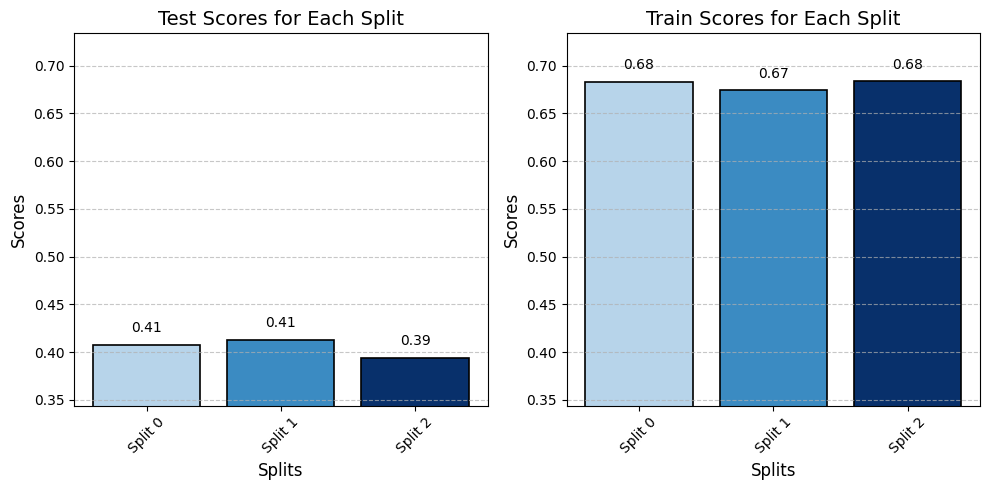

Mean train set score:  0.6804914637639549
Mean validation set score:  0.4047396540917482
Standard deviation train set:  0.004501987218918603
Standard deviation validation set:  0.00797789092525176


In [23]:
results = pd.DataFrame(grid_search_rf.cv_results_)
best_params = grid_search_rf.best_params_

best_results = results[
    (results['param_pca__n_components'] == best_params['pca__n_components']) &
    (results['param_regressor__n_estimators'] == best_params['regressor__n_estimators']) &
    (results['param_regressor__max_depth'] == best_params['regressor__max_depth']) &
    (results['param_regressor__min_samples_split'] == best_params['regressor__min_samples_split']) &
    (results['param_regressor__min_samples_leaf'] == best_params['regressor__min_samples_leaf'])
]
plot_test_train_scores(best_results, grid_search_rf.cv)

### Analiza rezultata
Prosečan R² score na trening skupu iznosi 0.6654, što znači da model objašnjava oko 66.5% varijanse u podacima za obučavanje. Iako je ovo dobar rezultat, prosečan R² score na validacionom skupu iznosi samo 0.3980, što ukazuje na značajan pad u sposobnosti modela da generalizuje na neviđene podatke. Ova razlika od približno 26.5% između trening i validacionih rezultata sugeriše da model pati od prekomernog učenja, odnosno da je previše prilagođen specifičnostima trening skupa.

Niska standardna devijacija na trening skupu (0.0034) ukazuje na to da model dosledno performira u različitim obukama, dok nešto viša standardna devijacija na validacionom skupu (0.0094) pokazuje da rezultati na neviđenim podacima variraju, ali ostaju relativno stabilni. Sve u svemu, ovi rezultati sugerišu da je potrebno dodatno raditi na optimizaciji hiperparametara kako bi se poboljšala sposobnost modela da generalizuje, smanjujući prekomerno učenje i povećavajući validacione rezultate

### Provera parametara na toplotnoj mapi
S obzirom na to da imamo pet hiperparametara, projekcija ukupne toplotne mape na dva parametra nije dovoljno informativna. Umesto toplotnih mapa možemo koristiti metodu za iscrtavanje paralelnih koordinata. Ova metoda omogućava vizualizaciju više hiperparametara zajedno kako bi se lakše analizirale njihove interakcije i uticaj na performanse modela.

Takođe, s obzirom na to da je pretraga hiperparametara randomizovana, neke od vrednosti mogu biti nedostupne.

In [24]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

cv_results = pd.DataFrame(grid_search_rf.cv_results_)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

df = cv_results.rename(columns=shorten_param)

fig = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df['mean_test_score'],
            colorscale='Viridis',
            showscale=True
        ),
        dimensions = list([
            dict(range = [100,200],
                label = 'n_estimators', values = df['n_estimators']),
            dict(range= [5,15],
                 label='max_depth', values = df['max_depth']),
            dict(range = [15,25],
                label = 'min_samples_split', values = df['min_samples_split']),
            dict(range = [4,6],
                label = 'min_samples_leaf', values = df['min_samples_leaf'])
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## Adaboost

In [25]:
# Hiperparametri
pipeline_ab = Pipeline([
    ('scalar',StandardScaler()),
    ('pca', PCA()),
    ('regressor', AdaBoostRegressor())
])

param_grid_ab = {
    'pca__n_components': [8, 9, 10, 11],
    'regressor__n_estimators': [10, 100, 1000],  # Number of boosting stages
    'regressor__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],  # Learning rate shrinks the contribution of each tree
}

In [26]:
# Unakrsna validacija
grid_search_ab = model_selection.GridSearchCV(pipeline_ab, param_grid_ab, cv=3, scoring='r2', return_train_score=True, n_jobs=-1)
grid_search_ab.fit(X_train, y_train)
best_model_ab = grid_search_ab.best_score_

print("Best cross-validation score for Adaboost: ",best_model_ab)
print("Best parameters for AdaBoost: ", grid_search_ab.best_params_)

Best cross-validation score for Adaboost:  0.26316732883089994
Best parameters for AdaBoost:  {'pca__n_components': 9, 'regressor__learning_rate': 0.01, 'regressor__n_estimators': 1000}


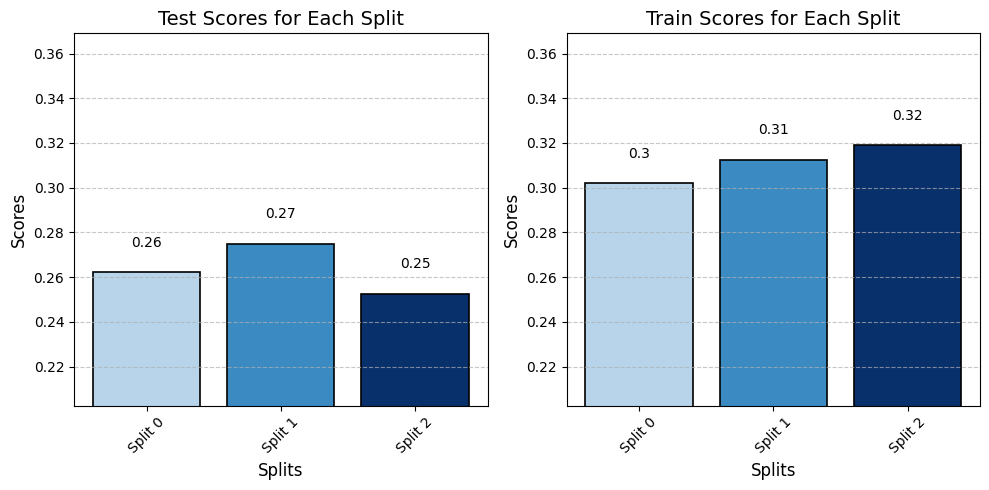

Mean train set score:  0.3111240988560822
Mean validation set score:  0.26316732883089994
Standard deviation train set:  0.007061249017967342
Standard deviation validation set:  0.009164714865106406


In [27]:
results = pd.DataFrame(grid_search_ab.cv_results_)
best_params = grid_search_ab.best_params_

best_results = results[
    (results['param_pca__n_components'] == best_params['pca__n_components']) &
    (results['param_regressor__n_estimators'] == best_params['regressor__n_estimators']) &
    (results['param_regressor__learning_rate'] == best_params['regressor__learning_rate'])
]

plot_test_train_scores(best_results, grid_search_ab.cv)

### Analiza rezultata

Prosečan R² score na trening skupu iznosi 0.3201, što znači da model objašnjava oko 32% varijanse u podacima za obučavanje. Ovaj rezultat ukazuje na to da model nije uspeo da uoči značajne obrasce u trening podacima.

Prosečan R² score na validacionom skupu je još niži, sa vrednošću od 0.2635, što sugeriše da model objašnjava samo 26.4% varijanse u neviđenim podacima. Ova razlika između trening i validacionih rezultata ukazuje na to da model ne generalizuje dobro, što može biti posledica prekomernog pojednostavljenja modela ili problema sa samim podacima.


Sve u svemu, rezultati sugerišu da je potrebna optimizacija hiperparametara ili možda upotreba složenijeg modela kako bi se poboljšala sposobnost modela da uči iz podataka i generalizuje na nove uzorke.

### Provera parametara na toplotnoj mapi
Možemo da koristimo toplotne mape da se uverimo da pretražujemo dobre skupove parametara. Iz ovih rezultata vidimo da možemo pretraživati i veće vrednosti za *regressor__n_estimators* parametar.

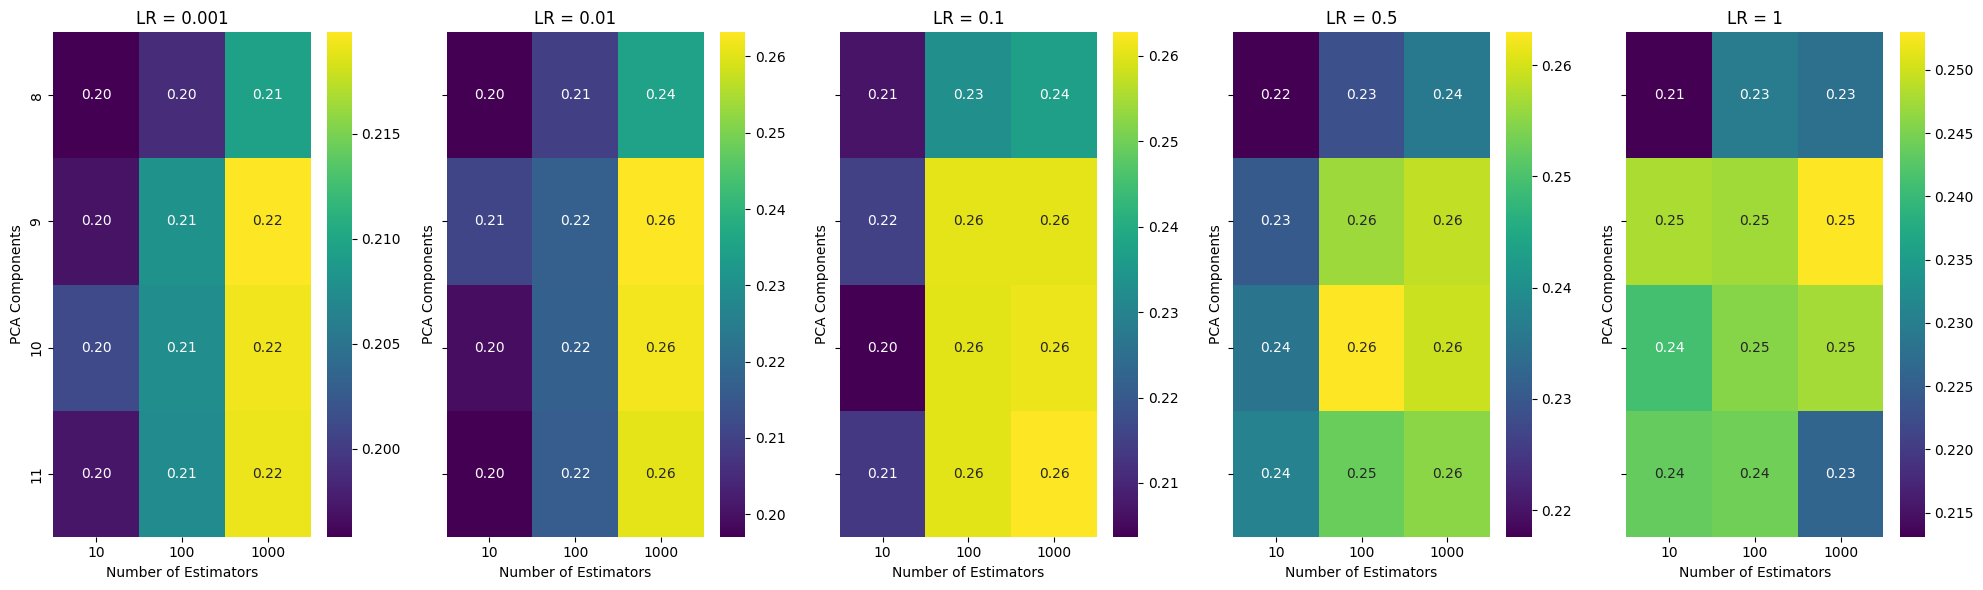

In [28]:
cv_results = pd.DataFrame(grid_search_ab.cv_results_)

cv_test_score = cv_results['mean_test_score'].values.reshape(5,3,4)

n_components = [8, 9, 10, 11]
n_estimators = [10, 100, 1000]
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]

fig, axs = plt.subplots(nrows=1, ncols=len(learning_rates), figsize=(20, 6), sharey=True)

# Iscrtavanje toplotnih mapa
for i, lr in enumerate(learning_rates):
    scores = cv_results[cv_results['param_regressor__learning_rate'] == lr]['mean_test_score'].values
    scores = scores.reshape(len(n_components), len(n_estimators))

    sb.heatmap(scores, xticklabels=n_estimators, yticklabels=n_components, cmap='viridis', annot=True, fmt='.2f', ax=axs[i])
    axs[i].set_xlabel('Number of Estimators')
    axs[i].set_ylabel('PCA Components')
    axs[i].set_title(f'LR = {lr}')

# Adjust layout
plt.tight_layout()
plt.show()

## Testiranje i čuvanje modela


In [29]:
models = []

### Linearna regresija


In [31]:
y_test_lr_pred = grid_search_lr.best_estimator_.predict(X_test)
# Testiranje finalong modela na test skupu
print("Linear model errors on test set: ")
models = models + [print_errors(y_test,y_test_lr_pred, 'Linear model')]

model_filename = 'models/models_01/model_lr.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(grid_search_lr.best_estimator_, model_file)

Linear model errors on test set: 
Mean Squared Error:  0.5472531229423575
Mean Absolute Error:  0.5735640896512599
Root Mean Squared Error:  0.7397655864815269
R-squared:  0.2824582795319921
Median Absolute Error:  0.47398644427257874
Explained Variance Score:  0.2829584450213657
Mean Absolute Percentage Error: 10.28%


### Naive-Bayes

In [32]:
y_test_nb_pred = grid_search_nb.best_estimator_.predict(X_test)
# Testiranje finalong modela na test skupu
print("Naive-Bayes model errors on test set: ")
models = models + [print_errors(y_test,y_test_nb_pred, 'Naive-Bayes model')]

model_filename = 'models/models_01/model_nb.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(grid_search_nb.best_estimator_, model_file)

Naive-Bayes model errors on test set: 
Mean Squared Error:  0.7384615384615385
Mean Absolute Error:  0.5587692307692308
Root Mean Squared Error:  0.8593378488473195
R-squared:  0.03175159612025347
Median Absolute Error:  0.0
Explained Variance Score:  0.03175358227082559
Mean Absolute Percentage Error: 10.00%


### SVR

In [33]:
y_test_svr_pred = grid_search_svr.best_estimator_.predict(X_test)
# Testiranje finalong modela na test skupu
print("SVR model errors on test set: ")
models = models + [print_errors(y_test,y_test_svr_pred, 'SVR model')]

model_filename = 'models/models_01/model_svr.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(grid_search_svr.best_estimator_, model_file)

SVR model errors on test set: 
Mean Squared Error:  0.45110760080690565
Mean Absolute Error:  0.5129469080604576
Root Mean Squared Error:  0.6716454427798239
R-squared:  0.4085213762530201
Median Absolute Error:  0.4026982446783176
Explained Variance Score:  0.4085552899878725
Mean Absolute Percentage Error: 9.14%


### Random Forest

In [34]:
y_test_rf_pred = grid_search_rf.best_estimator_.predict(X_test)
# Testiranje finalong modela na test skupu
print("Random forest model errors on test set: ")
models = models + [print_errors(y_test,y_test_rf_pred, 'Random forest model')]

model_filename = 'models/models_01/model_rf.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(grid_search_rf.best_estimator_, model_file)

Random forest model errors on test set: 
Mean Squared Error:  0.41509850638544954
Mean Absolute Error:  0.4957741572216601
Root Mean Squared Error:  0.6442813875826692
R-squared:  0.4557354102721336
Median Absolute Error:  0.39547155829375047
Explained Variance Score:  0.45607601203251424
Mean Absolute Percentage Error: 8.92%


### AdaBoost

In [35]:
y_test_ab_pred = grid_search_ab.best_estimator_.predict(X_test)
# Testiranje finalong modela na test skupu
print("AdaBoost model errors on test set: ")
models = models + [print_errors(y_test,y_test_ab_pred, 'AdaBoost model')]

model_filename = 'models/models_01/model_ab.pickle'
with open(model_filename, 'wb') as model_file:
    pickle.dump(grid_search_ab.best_estimator_, model_file)

AdaBoost model errors on test set: 
Mean Squared Error:  0.556856090448842
Mean Absolute Error:  0.5968594258469222
Root Mean Squared Error:  0.7462279078464179
R-squared:  0.26986715937692807
Median Absolute Error:  0.49194414607948467
Explained Variance Score:  0.27116014520564125
Mean Absolute Percentage Error: 10.71%


## Poređenje modela


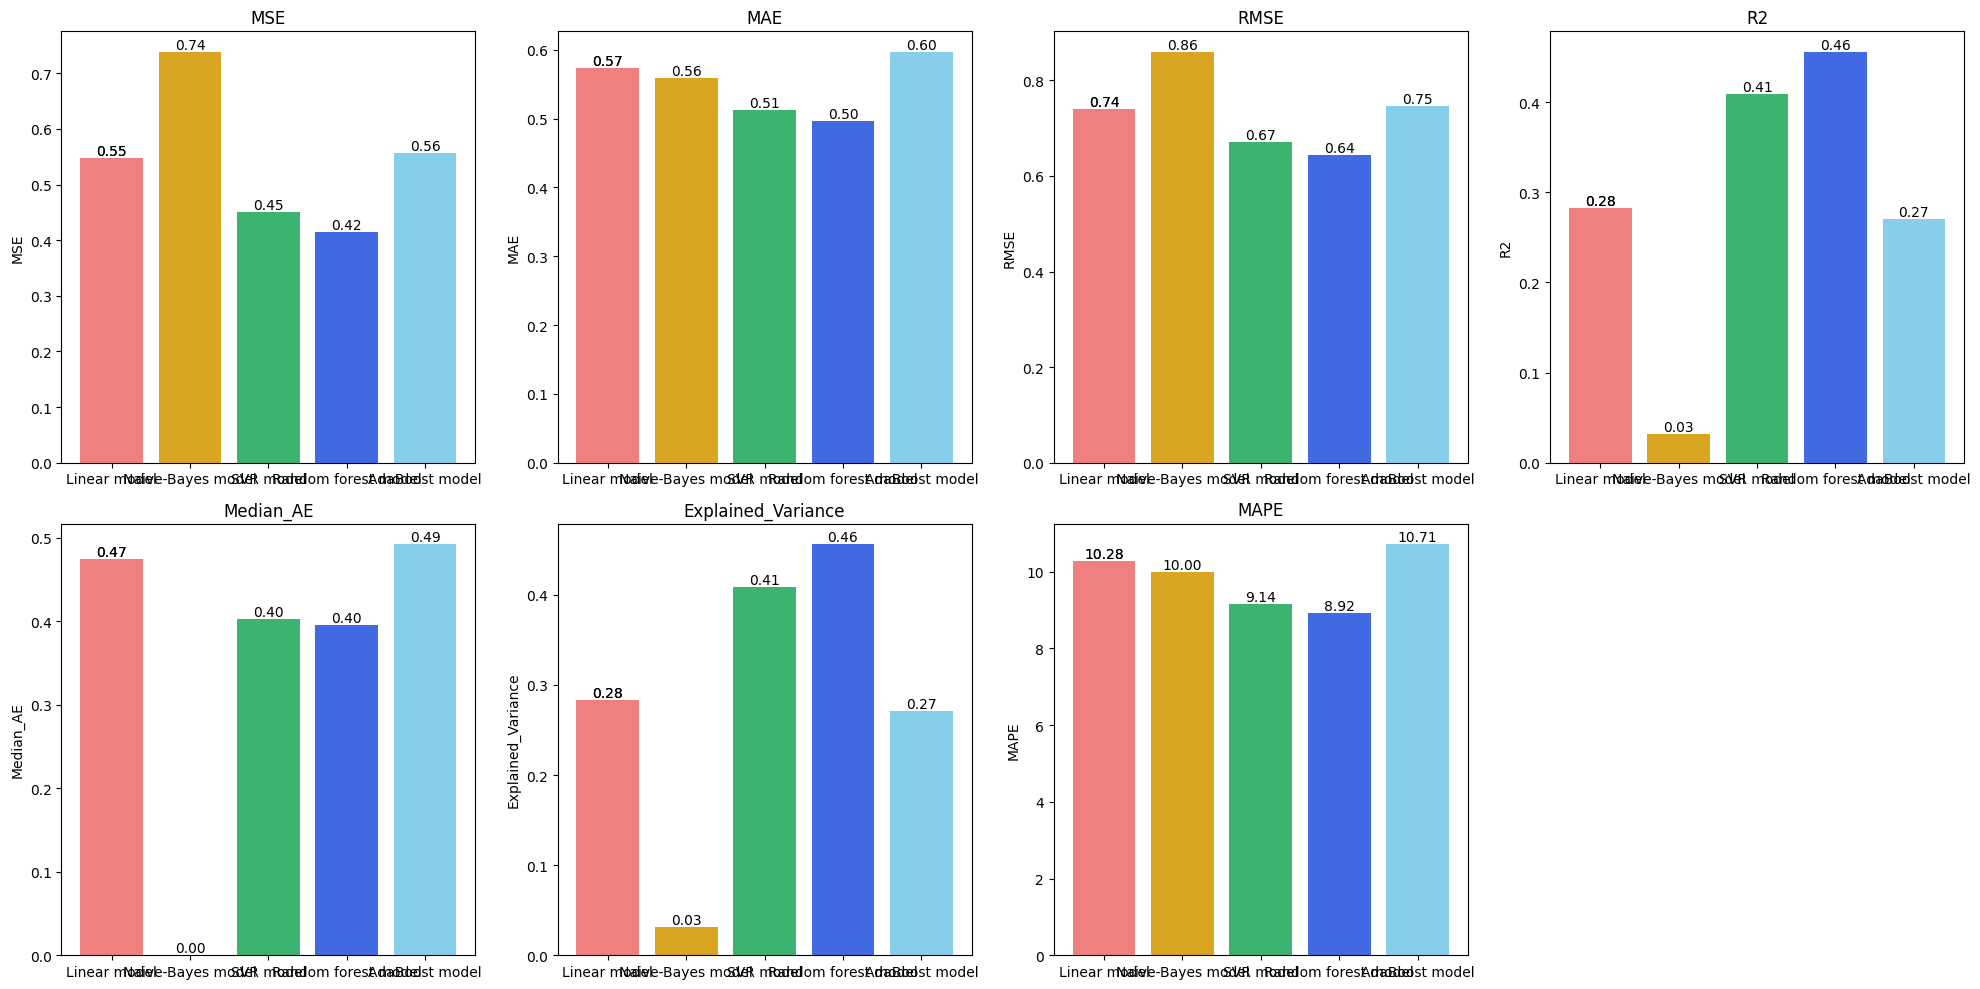

In [36]:
metric_names = ['MSE', 'MAE', 'RMSE', 'R2', 'Median_AE', 'Explained_Variance', 'MAPE']

model_names = [model["Model"] for model in models]
metric_values = {metric: [model[metric] for model in models] for metric in metric_names}

colors = [
    "skyblue",
    "lightcoral",
    "goldenrod",
    "mediumseagreen",
    "royalblue"
]

# Kreireamo histogram za svaku metriku
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, metric in enumerate(metric_names):
    row = i // 4
    col = i % 4

    bars = axs[row, col].bar(model_names, metric_values[metric], color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel(metric)

    # Tekst iznad barova
    for bar in bars:
        height = bar.get_height()
        axs[row, col].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

axs[1, 3].axis('off')

plt.tight_layout()
plt.show()

Linearna regresija je ostvarila R² score od 0.2825, što ukazuje na slabu sposobnost objašnjavanja varijanse u podacima. Ova greška je slična kao na validacionom skupu, tako da do preprilagođavanja verovatno nije došlo. Srednja kvadratna greška (MSE) iznosi 0.5473, dok je srednja apsolutna greška (MAE) 0.5736. Ove vrednosti ukazuju na visok nivo greške u predikcijama, dok je objašnjena varijansa od 0.2829 dodatno potvrđuje neefikasnost modela.

Naive-Bayes model je postigao R² score od 0.0318, što ukazuje na veoma nisku sposobnost objašnjavanja varijanse. MSE od 0.7385 i MAE od 0.5588 sugerišu da model gotovo ne može da uhvati važne obrasce u podacima. Zanimljivo je da je medijana apsolutne greške 0. Ovo se dešava jer ovaj model uvek predviđa cele brojeve (što vidimo i na grafiku pravih i predviđenih vrednosti). Ovo sugeriše da model predviđa tačne vrednosti za bar polovinu podataka. Dakle, model dobro radi za deo podataka, iako ukupna tačnost nije visoka. Ova karakteristika može ukazivati na to da model uspeva da precizno proceni određene podatke, dok u drugim slučajevima greške mogu biti značajne.

SVR (Support Vector Regression) model je ostvario R² score od 0.4042, što predstavlja značajno poboljšanje u odnosu na prethodne modele. Takođe, greška je čak manja nego na validacionom skupu, tako da do preprilagođavanja verovatno nije došlo. MSE iznosi 0.4544, a MAE 0.5087, što sugeriše da SVR model bolje generalizuje i pruža tačnije predikcije. Ova svojstva ga čine boljim izborom od Linearne regresije i Naive-Bayes modela.

Random Forest se ističe kao najbolji model sa R² score od 0.4456, objašnjavajući 44.56% varijanse u test skupu. Ova greška je solidno manja nego na validacionom skupu, tako da ne bi trebalo da je došlo do preprilagođavanja. Njegova MSE od 0.4228 i MAE od 0.5002 pokazuju visoku preciznost. Ove karakteristike sugerišu da Random Forest model uspešno hvata složenije obrasce u podacima.

AdaBoost je ostvario R² score od 0.2709, što ga čini inferiornim u odnosu na Random Forest i SVR, ali iznad Linearne regresije i Naive-Bayes modela. MSE od 0.5560 i MAE od 0.5941 ukazuju na to da model ima poteškoće u predikciji, ali i dalje pokazuje određenu stabilnost i nema preprilagođavanja.

Ukratko, Random Forest se pokazao kao najsposobniji model, dok SVR takođe ostvaruje dobre rezultate. Linearna regresija i Naive-Bayes modeli su znatno inferiorni, a AdaBoost pruža ograničene rezultate.

Na ovom grafiku prikazujemo REC (Regression Error Characteristic) krivu za različite regresione modele. Grafikon prikazuje kako se tačnost modela menja u zavisnosti od nivoa tolerancije na greške.

Na X-osi je prikazana tolerancija, što predstavlja maksimalnu dozvoljenu grešku između stvarnih i predviđenih vrednosti. Na Y-osi je prikazana tačnost, koja pokazuje koliki deo predikcija modela zadovoljava ovu toleranciju.

Svaka linija na grafiku predstavlja jedan od modela (LR, NB, SVR, RF, AB) i pokazuje kako se njegova tačnost menja sa promenom nivoa tolerancije.

Na REC krivama, Naive Bayes model prikazuje skokovit obrazac zbog svojih celobrojnih predikcija. Ovaj model se pokazuje kao najbolji sa tolerancijom od 1. Random Forest i SVR imaju generalno najbolje rezultate.

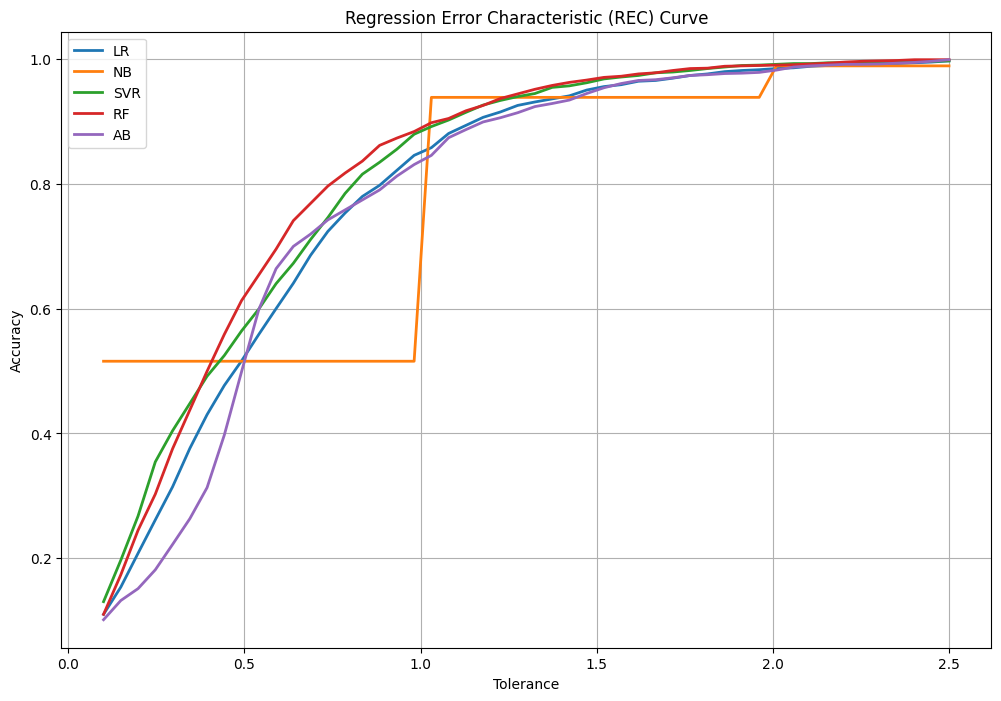

In [37]:
def calculate_accuracy_with_tolerance(true_values, predictions, tolerance):
    true_values = np.array(true_values)
    predictions = np.array(predictions)
    return np.mean(np.abs(true_values - predictions) <= tolerance)

tolerances = np.linspace(0.1, 2.5, 50)
accuracies = [
    [calculate_accuracy_with_tolerance(y_test, y_test_lr_pred, tol) for tol in tolerances],
    [calculate_accuracy_with_tolerance(y_test, y_test_nb_pred, tol) for tol in tolerances],
    [calculate_accuracy_with_tolerance(y_test, y_test_svr_pred, tol) for tol in tolerances],
    [calculate_accuracy_with_tolerance(y_test, y_test_rf_pred, tol) for tol in tolerances],
    [calculate_accuracy_with_tolerance(y_test, y_test_ab_pred, tol) for tol in tolerances]
]
names = ['LR', 'NB', 'SVR', 'RF', 'AB']

# Plot REC Curve for all models
plt.figure(figsize=(12, 8))

for i in range(5):
    plt.plot(tolerances, accuracies[i], lw=2, label=names[i])

plt.xlabel('Tolerance')
plt.ylabel('Accuracy')
plt.title('Regression Error Characteristic (REC) Curve')
plt.grid(True)
plt.legend()
plt.show()

Zaključujemo da metoda slučajne šume postiže najbolje rezultate na test skupu u svim metrikama koje smo koristili.

### Značaj pojedinačnih atributa
Istražićemo značaj pojedinačnih atributa. S obzirom da smo koristili PCA, treba mapirati važnost novih atributa na važnost originalnih atributa.

Vidimo da je količina alkohola u vinu atribut koji najviše utiče na kvalitet vina, dok gustina najmanje utiče na kvalitet vina.


### Linearna regresija

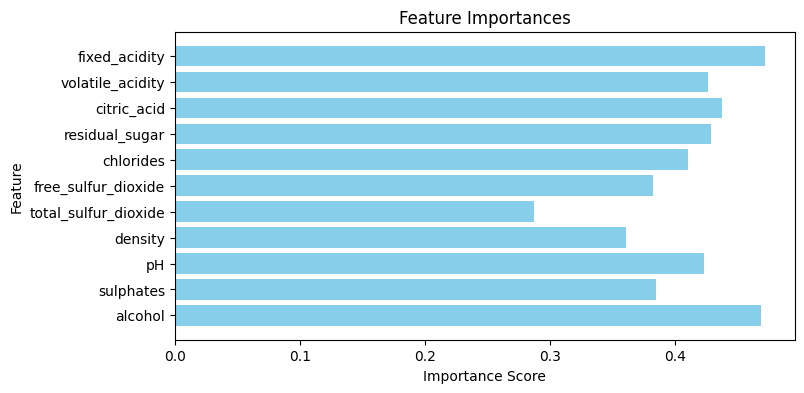

In [39]:
scalar = grid_search_lr.best_estimator_.named_steps['scalar']
pca =  grid_search_lr.best_estimator_.named_steps['pca']
lr =  grid_search_lr.best_estimator_.named_steps['regressor']
original_feature_names = wine_quality.data.headers.to_numpy()[:-2]

components = abs(pca.components_)
norms = np.linalg.norm(components, axis=1, keepdims=True)
components = components / norms

regressor_coefficients = abs(lr.coef_)  # Extract coefficients from the regressor

# Map regression coefficients back to the original feature space
importance_scores = np.dot(regressor_coefficients, components)

# Take the absolute value to get feature importances
importance_scores = np.abs(importance_scores)

plt.figure(figsize=(8, 4))
plt.barh(original_feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Slučajna šuma

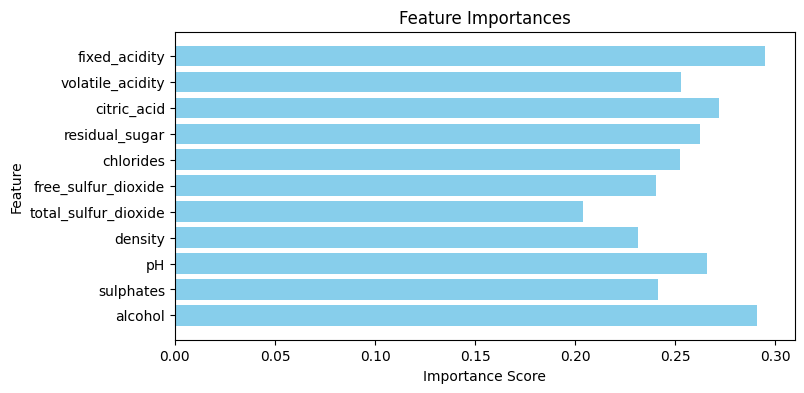

In [46]:
scalar = grid_search_rf.best_estimator_.named_steps['scalar']
pca =  grid_search_rf.best_estimator_.named_steps['pca']
rf =  grid_search_rf.best_estimator_.named_steps['regressor']
original_feature_names = wine_quality.data.headers.to_numpy()[:-2]

components = abs(pca.components_)
norms = np.linalg.norm(components, axis=1, keepdims=True)
components = components / norms

importances_pca = rf.feature_importances_ # važnost novih atributa

importance_scores = np.abs(components.T @ importances_pca) # doprinos originalnih atributa u važnosti novih atributa

plt.figure(figsize=(8, 4))
plt.barh(original_feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### SVR

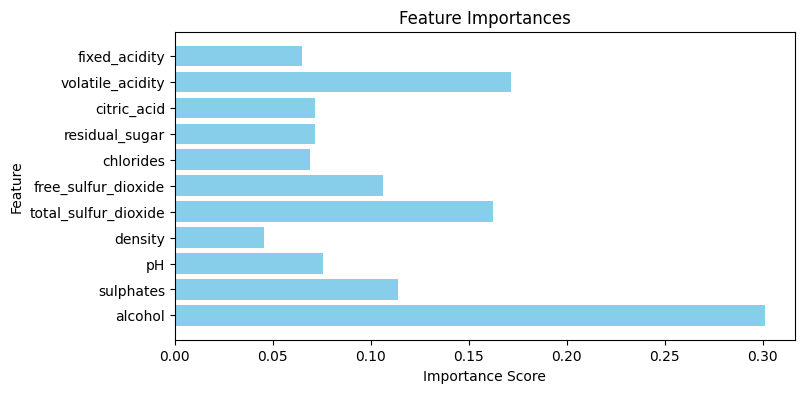

In [45]:
scalar = grid_search_svr.best_estimator_.named_steps['scalar']
pca =  grid_search_svr.best_estimator_.named_steps['pca']
svr =  grid_search_svr.best_estimator_.named_steps['svr']
original_feature_names = wine_quality.data.headers.to_numpy()[:-2]

result = permutation_importance(grid_search_svr.best_estimator_, X_train, y_train, n_repeats=3, random_state=42, n_jobs=-1)

# Ispis važnosti osobina
importances = result.importances_mean

plt.figure(figsize=(8, 4))
plt.barh(original_feature_names, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()